### **Introduction**
This notebook is for peak, firing rate, amplitude, and synchronization index analyzing on Calcium imaging traces. The synchronization indices are evaluated based on distances between cells in section 5.

*You have to export the ROI traces in inscopix analyze software or using caiman code. Obtain a trace (csv) file first before you start the analysis here.
After executing the code, you will get some more csv files to do statistical analysis.*

#### Plotting using Prism software is recommended.

Hopefully this code can help you out.
Good luck!

The code is mostly attributed to Alison Liu and refined by Hsin-Yu Cheng. 2024-2025

### Import package

In [7]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, hilbert
import matplotlib.pyplot as plt
import seaborn as sns

### Import data and preprosessing

In [10]:
# 載入和處理數據
'''
輸入檔案的路徑和檔名、基因型和編號，以便程式自動寫入需要分析的trace(.csv)檔以及輸出結果
'''
data_dir = input("Paste your file directory, include the path and '.csv': ")
genotype = str(input('The genotype for the experience sample, e.g. NT, KO, Re: '))
data_num = str(input('The number of the sample, (e.g. NT no.1 fov.1 can be written as 1-1): '))


cols = list(pd.read_csv(data_dir, header = 1))
# print(cols) #check the column of the traces file, basically exported from inscopix_analysis software

data = pd.read_csv(data_dir, header = 1,
                   usecols = [i for i in cols if i != 'Time(s)/Cell Status']) #get rid of the time column for visualization

'''
load data into pd dataframe
'''
# data = data.drop(labels=0).reset_index(drop=True)
data = data.apply(pd.to_numeric, errors='coerce')
time_stamps = data.iloc[:, 0].tolist() # get timestamp list
#data.drop(data.columns[0], axis=0, inplace=True) # remove time column, 只包括細胞訊號變化


Paste your file directory, include the path and '.csv':  /Users/hycheng/Desktop/MS/Thesis/Exp/HSHuangLab-CalciumRepo/Calcium_imaging_analysis/Sample trace.csv
The genotype for the experience sample, e.g. NT, KO, Re:  NT
The number of the sample, (e.g. NT no.1 fov.1 can be written as 1-1):  


### 1. Calcium trace

frame rate: (default: 10.5) 10.5


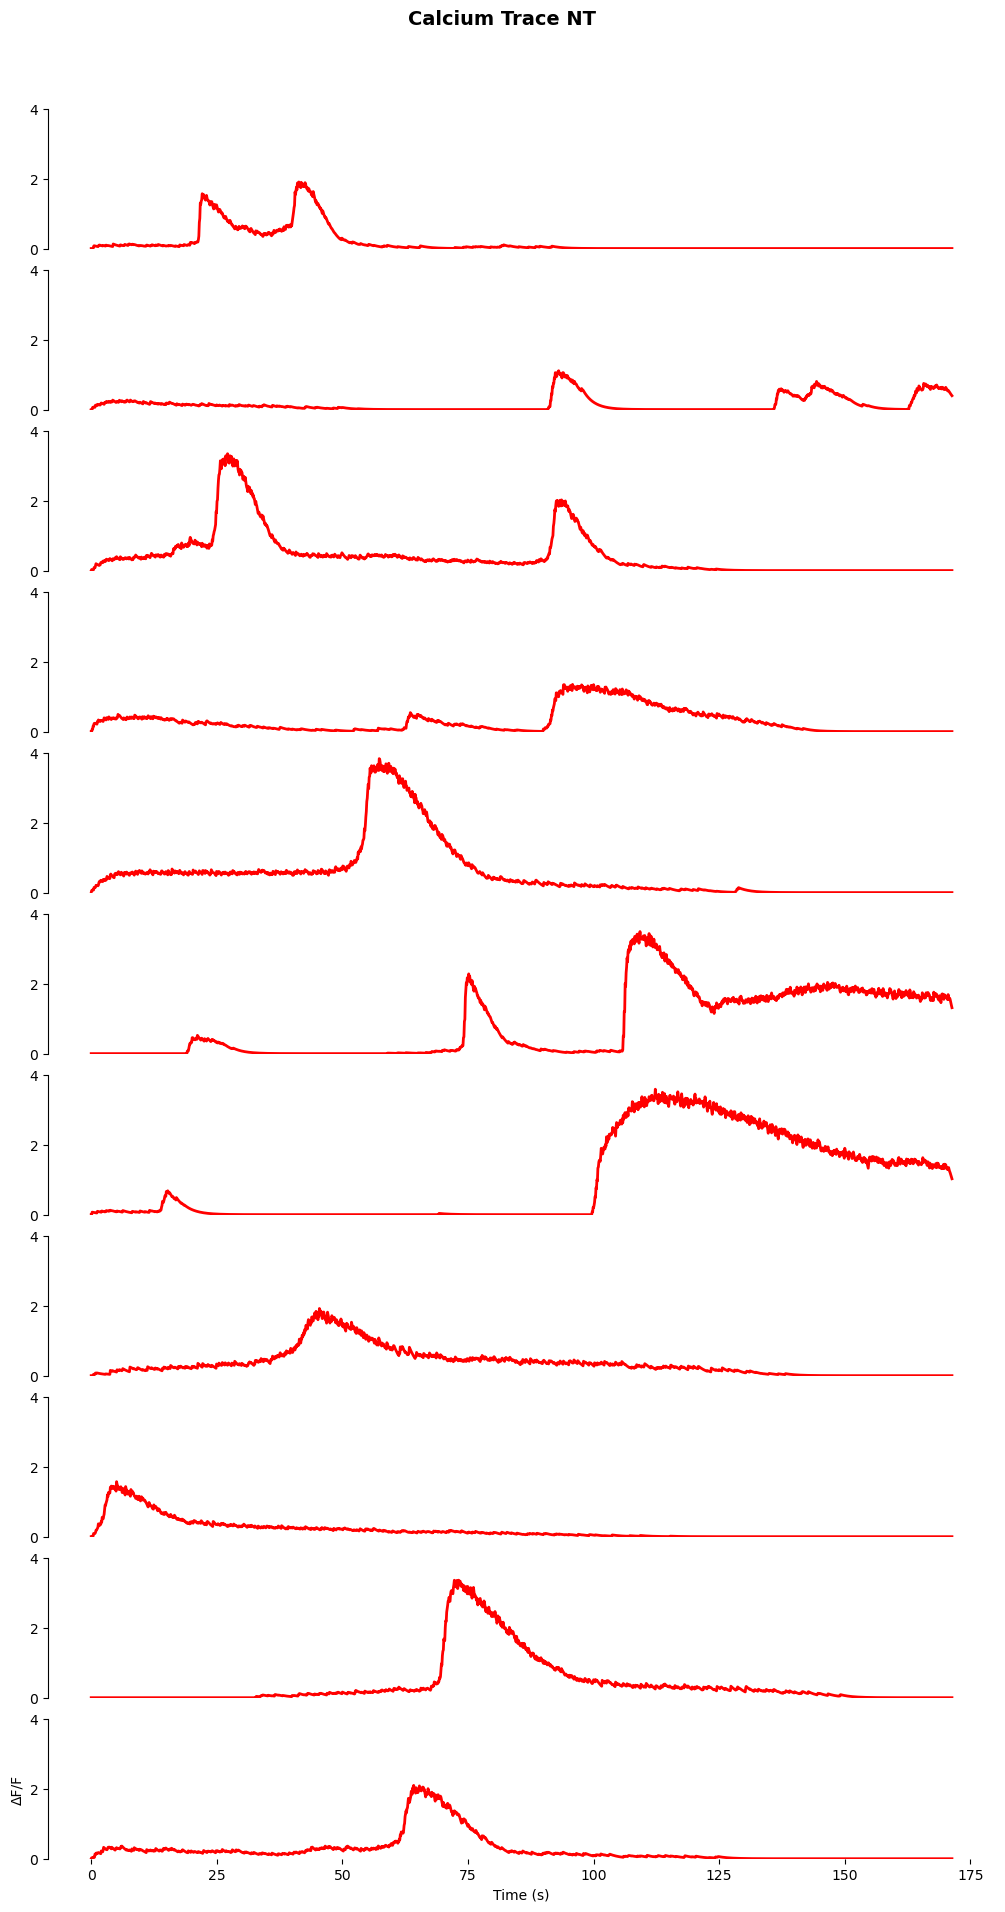

In [15]:
# 設定幀率並計算每幀時間
frame_rate = float(input('frame rate: (default: 10.5)') or 10.5)  # Hz
time_per_frame = 1 / frame_rate  # seconds

all_time = len(time_stamps) * time_per_frame

# 定義x軸值為時間（秒）
x = [i * time_per_frame for i in range(len(data))]

# 創建新圖形
tracemap = plt.figure(figsize=(10, 20))  # 根據需要調整高度

# 循環繪製每個子圖
for i, column in enumerate(data.columns):
    ax = plt.subplot(len(data.columns), 1, i+1)
    
    # 對於每個子圖計算自己的y軸最大值和最小值
#     y_max = data[column].max()
    y_max = 4 # 20250908 老師說每張圖的scale要一樣
    y_min = data[column].min()
    
    ax.plot(x, data[column], color='red', linewidth=2) #記得改trace顏色
    ax.set_ylim(y_min, y_max)  # 使用子圖的y軸範圍
    ax.yaxis.set_major_locator(plt.MaxNLocator(2))
#     ax.set_title(column, loc='left')
    # 移除每個圖y軸以外的邊界跟標題
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    

    # 除了最後一個子圖外，都移除x軸標題
    if i < len(data.columns) - 1:
        ax.xaxis.set_visible(False)
    else:
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('ΔF/F')

# 新增總標題
plt.suptitle('Calcium Trace ' + genotype, fontsize=14, fontweight='bold')

# 調整佈局並顯示圖形
plt.tight_layout(pad=0.54, rect=[0, 0.03, 1, 0.95])
plt.show()
tracemap.savefig(genotype+"_trace.eps", format='eps')

### 2-1 Frequency

調整`slope_window`、`valley_window`和`detect_window`這三個參數的大小會以不同的方式影響峰值偵測的結果：

1. **`slope_window`（斜率視窗大小）**:這個參數決定了在計算波峰附近平均斜率時所使用的資料點的數量。較大的`slope_window`會使斜率計算更加平滑，可能會減少因訊號雜訊造成的誤差，但同時可能會錯過較小的波峰。較小的`slope_window`會使斜率計算更敏感於訊號中的小變化，可能增加偵測到的峰值數量，但也可能增加由雜訊引起的誤檢。

2. **`valley_window`（谷窗口大小）**:這個參數定義了在波峰之後用來尋找最低點（谷）的資料範圍。較大的`valley_window`允許在更遠的範圍內尋找谷點，有助於識別寬波形的波峰和谷，但也可能將較遠的無關波谷錯誤地關聯到當前波峰。較小的`valley_window`限制了搜尋範圍，可能錯過一些較寬的波形，但減少了錯誤關聯的風險。

3. **`detect_window`（檢測視窗大小）**:這個參數用於確保在特定範圍內只檢測到一個波峰，以避免在訊號的局部區域內標記多個相近的峰值。較小的`detect_window`使峰值偵測更加寬鬆，可能在短距離內識別多個峰值，適用於訊號變化快速的情況。較大的`detect_window`增加了峰值之間的最小距離，有助於減少因訊號快速變化造成的多重偵測，但可能錯過一些有效的峰值。

調整這些參數需要根據訊號的特性和分析的目標來進行。通常，需要透過試驗和錯誤的方法來找到最佳的參數設置，這可能涉及查看多個訊號樣本的檢測結果，並根據實際檢測到的峰值的品質和數量來調整參數。在實際應用中，可能需要為不同類型的訊號或不同的分析目的使用不同的參數設定。

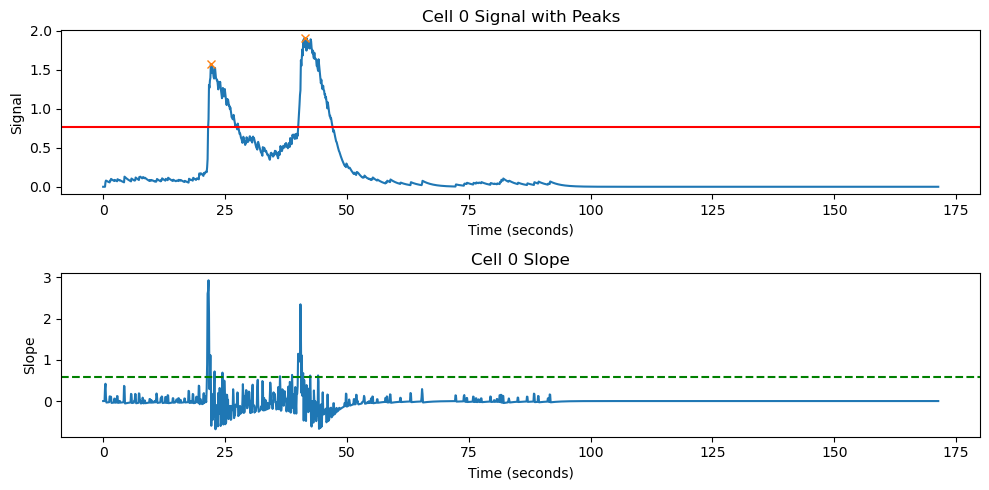

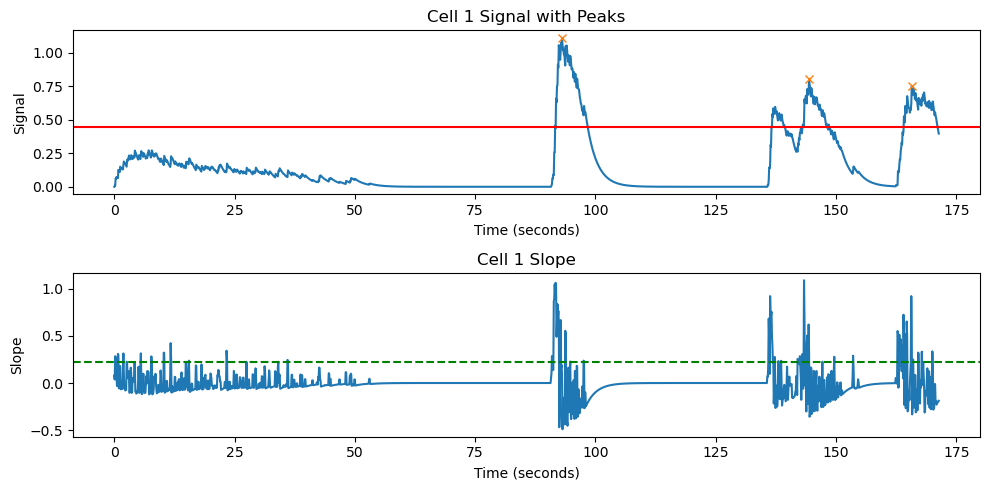

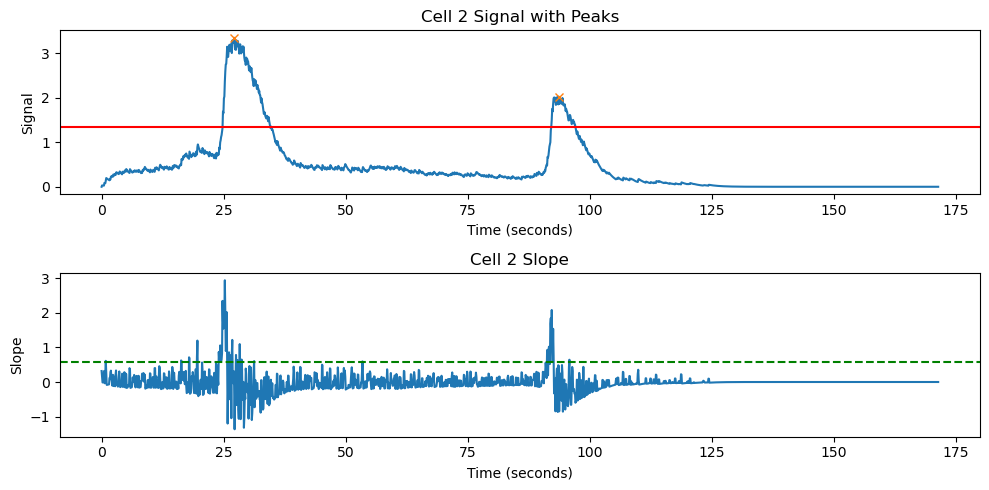

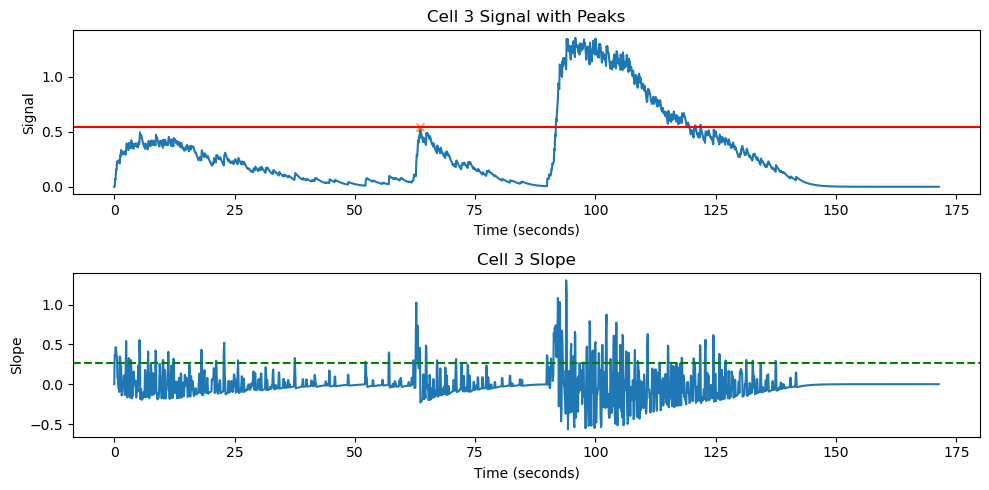

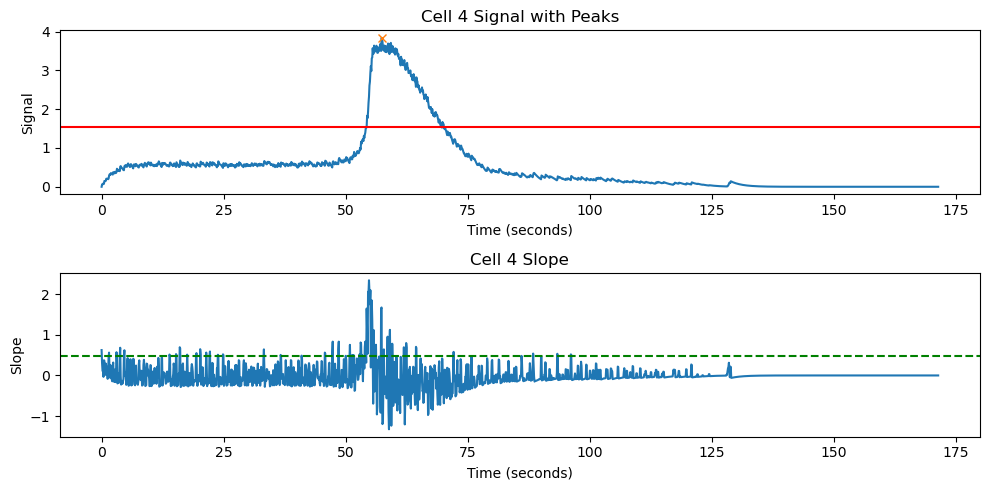

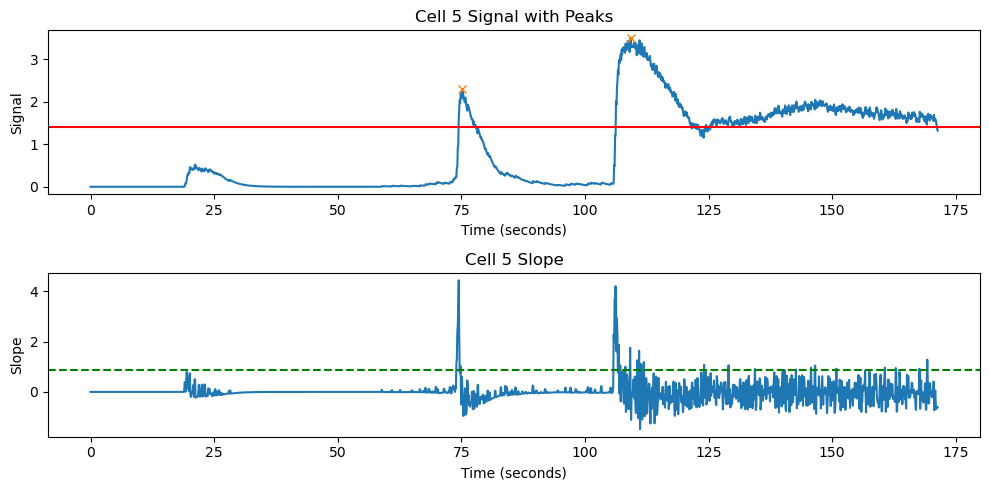

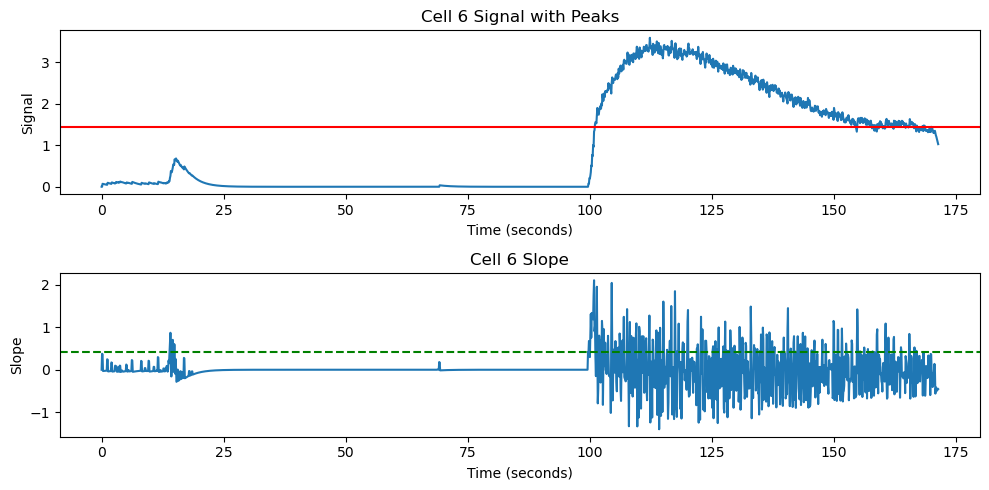

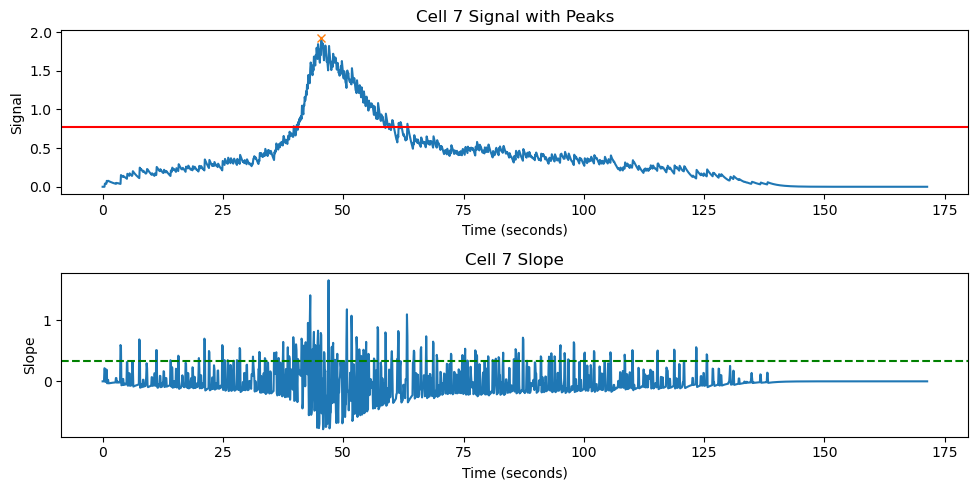

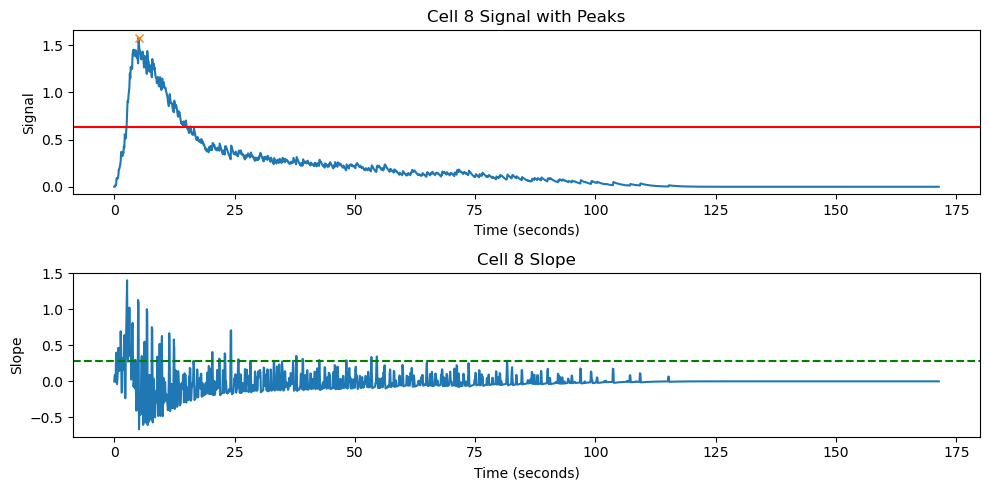

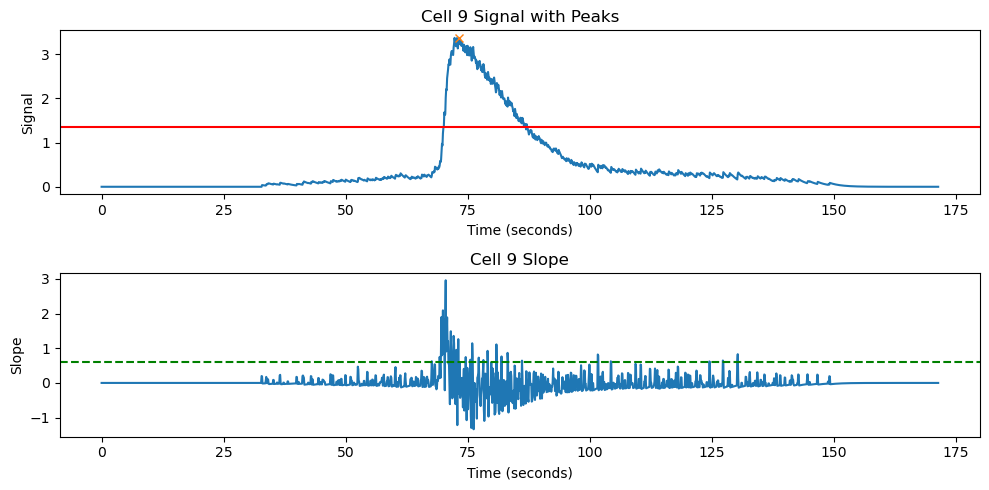

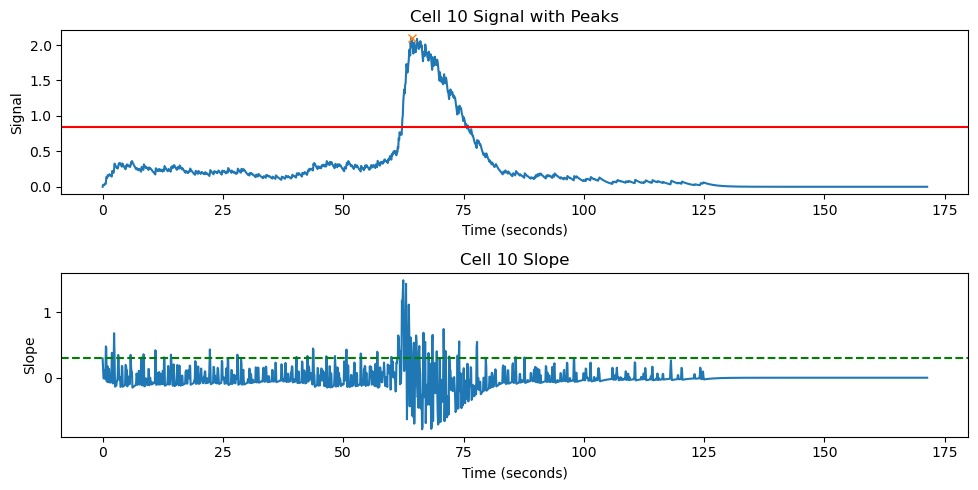

In [25]:
def calculate_slope(signal, pertime):
    return np.gradient(signal, pertime)  # 用np.gradient得到精細的斜率

'''
data type of signal:
'''
def detect_peaks(signal, frame_rate, detect_window, valley_window, slope_window=5):   
    # 計算訊號的斜率
    slope = calculate_slope(signal, 1/frame_rate)

    # 計算斜率的閾值
    slope_threshold = max(np.percentile(slope, 90), np.max(slope) * 0.2)


    # 計算訊號的閾值
    threshold_x = np.max(signal) * 0.4

    # 使用 scipy 的 find_peaks 函數找到波峰
    peaks, _ = find_peaks(signal, distance=detect_window)
#     peaks, _ = find_peaks(signal)
    valid_peaks = []   

    # 遍歷找到的波峰
    for peak in peaks:
        # 確保波峰周圍有足夠的數據用於斜率計算
        if peak >= slope_window // 2 and peak <= len(signal) - (slope_window // 2) - 1:
            # 計算波峰左側的平均斜率
            left_slope = np.mean(slope[max(0, peak - (slope_window // 2)):peak])

            # 檢查波峰是否滿足閾值條件和斜率條件
            if signal[peak] > threshold_x and left_slope > 0: # left_slope should be larger than slope_threshold but 0 is for my data to run QQ
                # 在波峰之後的 valley_window 範圍內尋找最低點
                valley_end = min(peak + valley_window + 1, len(signal))
                min_valley_point = np.min(signal[peak + 1:valley_end])

                # 檢查找到的最低點是否符合條件
                if min_valley_point < threshold_x:
                    # 在detect_window範圍內選擇最明顯的波峰
                    detect_start = max(0, peak - detect_window // 2)
                    detect_end = min(peak + detect_window // 2 + 1, len(signal))
                    if peak == np.argmax(signal[detect_start:detect_end]) + detect_start:
                        valid_peaks.append(peak)

    # 傳回有效波峰的索引，訊號閾值，斜率數組和斜率閾值
    return valid_peaks, threshold_x, slope, slope_threshold


# values of three Criterias (changeable parameters)
slope_window = 10      # 斜率視窗大小，用於計算波峰附近的平均斜率，預設值建議try：5或10
valley_window = 180    # 谷窗口大小，用於在波峰後尋找最低點，越大越寬鬆
detect_window = 100     # 偵測視窗大小，確保在此範圍內只標記一個波峰，越小越寬鬆


frame_rate = 10.5
# 計算每個幀對應的時間（秒）
time = np.arange(len(data)) / frame_rate

# 初始化peak_counts (每個ROI的波峰數量), isi (每個ROI的波峰間距)
peak_counts = []
isi = []

for i, signal in enumerate(data.columns):
    signal_data = data[signal].astype(float)
    valid_peaks, threshold_x, slope, slope_threshold = detect_peaks(signal_data, frame_rate, detect_window, valley_window, slope_window)
    
    # 寫入peak_counts的list
    peak_counts.append(len(valid_peaks))
    if len(valid_peaks) > 1:
        for isiind in range(len(valid_peaks)-1):
            isi.append((valid_peaks[isiind+1]-valid_peaks[isiind])/frame_rate)
    
    # 繪製data frame每一列的數據
    plt.figure(figsize=(10, 5))

    # 繪製訊號和波峰
    plt.subplot(2, 1, 1)
    plt.plot(time, signal_data, label='Signal')  # 使用時間作為橫座標
    plt.plot(time[valid_peaks], signal_data[valid_peaks], "x", label='Peaks')  # 波峰處使用時間索引
    plt.axhline(y=threshold_x, color='r', linestyle='-', label='Threshold (thre_x)')
    plt.title(f"Cell {i} Signal with Peaks")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Signal')
    

    # 繪製斜率
    plt.subplot(2, 1, 2)
    plt.plot(time, slope, label='Slope')  # 使用時間作為橫座標
    plt.axhline(y=slope_threshold, color='g', linestyle='--', label='Slope Threshold')
    plt.title(f"Cell {i} Slope")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Slope')
    

    plt.tight_layout()
    plt.show()


In [27]:
print(peak_counts)
print(threshold_x)
# Save the peakcounts into csv file
df_peak_counts = pd.DataFrame(peak_counts)
df_peak_counts.to_csv(genotype + data_num + "peak_counts.csv")

[2, 3, 2, 1, 1, 2, 0, 1, 1, 1, 1]
0.8410468


### 2-2 peak to peak interval


In [30]:
print(isi)

# Save the peakcounts into csv file
df_isi = pd.DataFrame(isi)
df_isi.to_csv(genotype + data_num + "_isi.csv")

[19.238095238095237, 51.333333333333336, 21.333333333333332, 66.47619047619048, 34.095238095238095]


### Calculating frequency

In [ ]:
# 使用給定的波峰數量數組
peak_counts = np.array(peak_counts)   # peak_counts was list type

# 觀測時間長度為 total_time_seconds（總秒數），以計算頻率
# total_time_seconds = time_stamps[-1]
# 因為time_stamps我覺得不好用所以我改成all_time :P by HY

# 以波峰數除以總時間來計算頻率，轉換為Hz
cell_frequencies_Hz = peak_counts / all_time

# 計算平均頻率
average_frequency_Hz = np.mean(cell_frequencies_Hz)

In [166]:
print (cell_frequencies_Hz)
# Saving all recorded cell frequency to a csv file
df_cell_frequencies_Hz = pd.DataFrame(cell_frequencies_Hz)
df_cell_frequencies_Hz.to_csv(genotype + data_num +"cell_frequencies_Hz.csv")

[0.         0.01166667 0.00583333 0.00583333]


### 3 Amplitude

函數 calculate_amplitudes，用於計算給定訊號中每個峰值的振幅。這個函數遍歷訊號的每一列，對於每個訊號，它首先偵測峰值，然後偵測谷值（作為峰值的相反數來找出），接著為每個峰值計算振幅（峰值與最近的谷值之間的差值的絕對值）。最後，函數傳回所有訊號的所有振幅。

In [ ]:
def calculate_amplitudes(signals, frame_rate):
    average_amplitudes_all_signals = []  # 儲存每個訊號的平均振幅
    for column in signals:  # 遍歷每一列，即每個細胞的訊號
        signal = signals[column].values  # 取得目前列的訊號值

        # 檢測訊號中的峰值
        peaks, _, _, _ = detect_peaks(signal, frame_rate, detect_window, valley_window, slope_window)

        # 使用訊號的負值來尋找谷值
        valleys, _ = find_peaks(-signal)

        # 計算振幅
        amplitudes = []
        for peak in peaks:
            # 找到位於峰值之前的所有谷值
            previous_valleys = [valley for valley in valleys if valley < peak and signal[valley] <= threshold_x] # and 以後是為了修正valleys抓到雜訊導致的谷值讓amplitude計算太低
            if previous_valleys:
                nearest_valley = previous_valleys[-1]  # 最近的谷值
                amplitude = np.abs(signal[peak] - signal[nearest_valley])  # 計算振幅
                amplitudes.append(amplitude)

        # 如果存在振幅，則計算平均振幅並加入結果清單中
        if amplitudes:
            average_amplitude = np.mean(amplitudes)
            average_amplitudes_all_signals.append(average_amplitude)
        else:
            average_amplitudes_all_signals.append(0)  # 沒有有效的振幅時回傳0

    return average_amplitudes_all_signals

# 計算每個細胞信號的平均振幅
amplitudes = calculate_amplitudes(data, frame_rate)

In [168]:
print(amplitudes)

df_amplitudes = pd.DataFrame(amplitudes)
df_amplitudes.to_csv(genotype + data_num +"amplitudes.csv")

[0, 0.23135255000000005, 0.22470830000000003, 0.8108728000000001]


### 4-1 Plotting heat map (no z score)

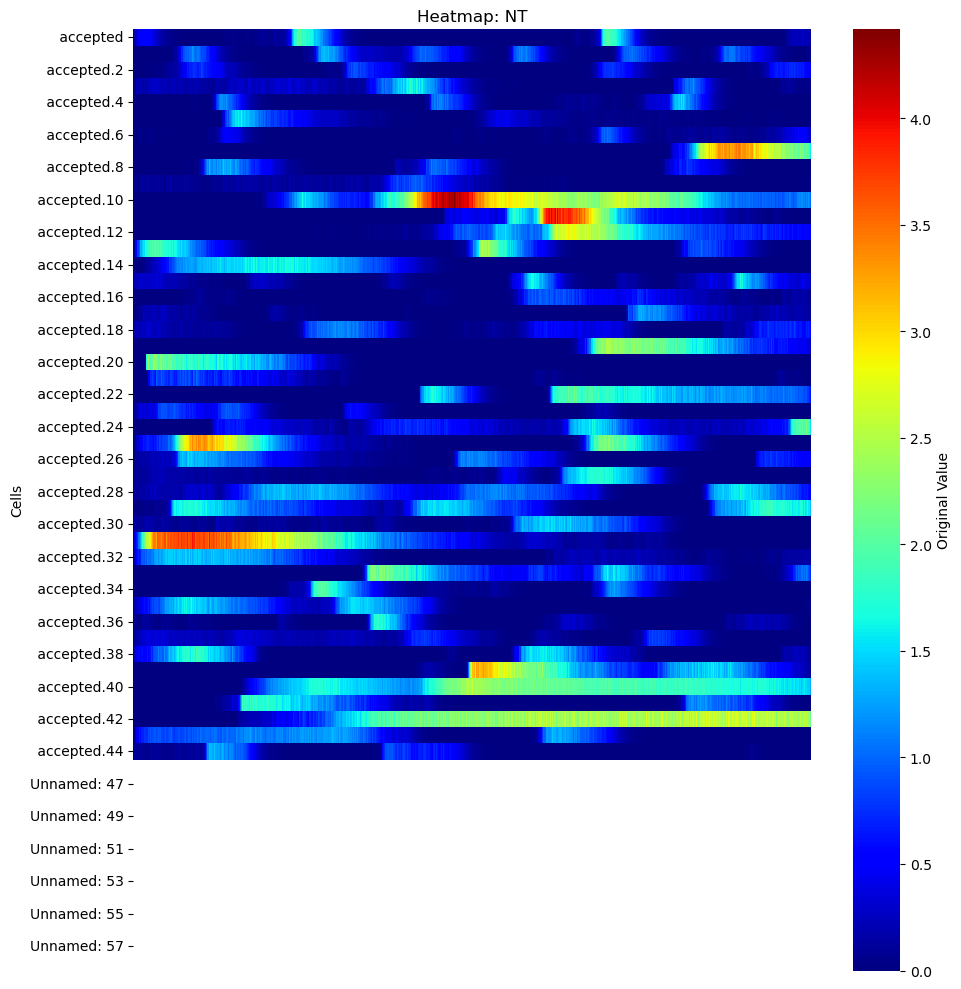

In [274]:
# 使用原始資料建立熱圖
heatmap_nonZ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(data.T,
                 cmap='jet', cbar_kws={'label': 'Original Value'})

# 設定圖的標題和軸標籤
ax.set_title('Heatmap: '+genotype)
ax.set_xlabel('')  # Removing the x-axis label
ax.set_ylabel('Cells')

# Hiding the x-axis (time) ticks
ax.set_xticks([])

plt.tight_layout()
plt.show()
heatmap_nonZ.savefig(genotype+"_heatmap_nonZ.eps", format='eps')

### 4-2 Plotting heat map(with z score)

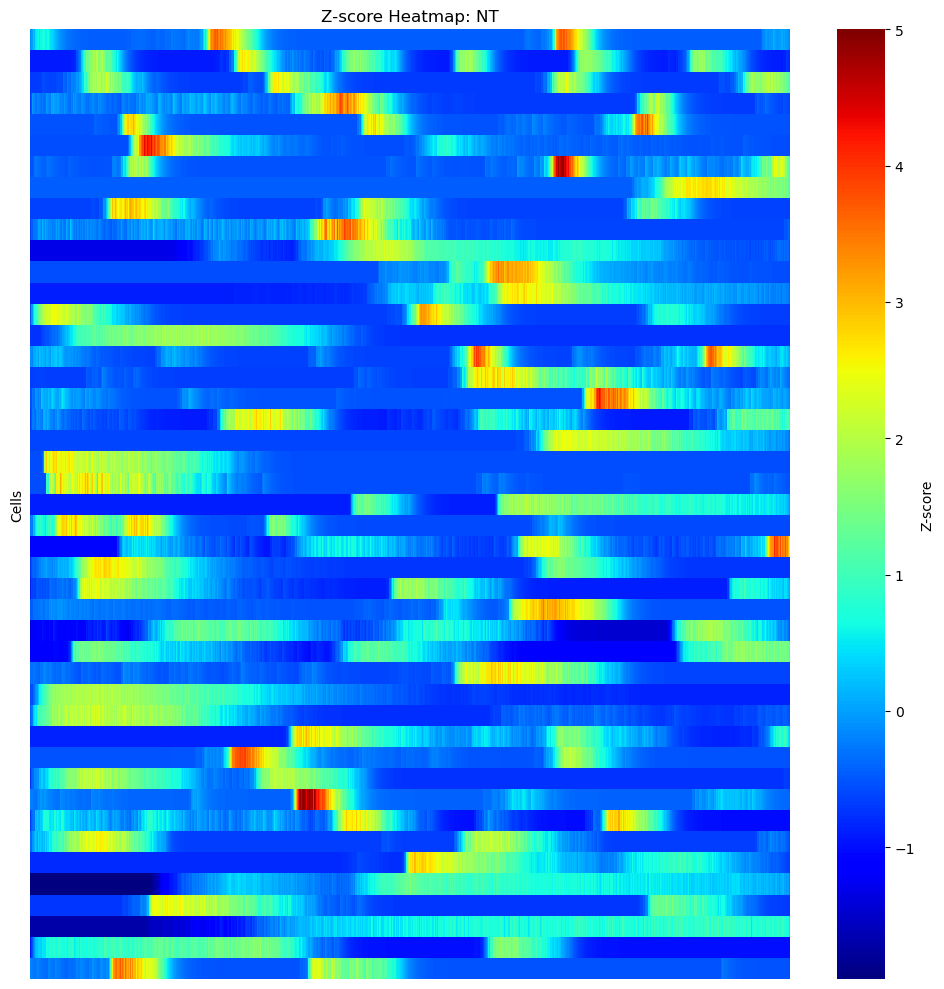

In [17]:
# 計算剩餘列的z分數
z_scores_cleaned = (data - data.mean()) / data.std(ddof=0)

# 創建熱圖
heatmap_Z = plt.figure(figsize=(10, 10))
ax = sns.heatmap(z_scores_cleaned.T, vmax=5,  # vmax可以統一上限
                 yticklabels=False,
                 cmap='jet', cbar_kws={'label': 'Z-score'})

# 設定圖的標題和軸標籤
ax.set_title('Z-score Heatmap: ' + genotype)
ax.set_xlabel('')  # Removing the x-axis label
ax.set_ylabel('Cells')

# Hiding the x-axis (time) ticks
ax.set_xticks([])

plt.tight_layout()
plt.show()
heatmap_Z.savefig(genotype+"_heatmap_Z.eps", format='eps')

Red: Higher z-scores, indicating values significantly higher than the mean.

Blue: Lower z-scores, indicating values significantly lower than the mean.

Yellow/Green: Z-scores near zero, indicating values close to the mean.

### 5 Synchronization Index

1. 計算瞬時相位：對每個細胞的訊號使用希爾伯特變換計算瞬時相位，為每個訊號的每個時間點賦予一個相位值。
    - 瞬時相位與訊號的頻率、振幅和相位有關。透過對訊號進行希爾伯特變換，可以從原始訊號中提取出瞬時相位訊息，這一訊息反映了訊號在每個時刻的周期性變化狀態。具體而言，瞬時相位能夠表徵訊號在其週期內的具體位置，是對訊號時間特性的一種量測，它與訊號的頻率變化和振幅變化緊密相關，能夠揭示訊號的時間動態特性和訊號源的行為模式。 
    

2. 相位差異：對於每一對細胞訊號，計算它們在同一時間點的瞬時相位差。這需要兩個訊號的瞬時相位長度相同，或在比較時只考慮共同的時間點。
    - 希爾伯特變換 (hilbert(signal_data)): 對訊號進行希爾伯特變換，產生每個時刻的複數表示。這個複數的實部是原始訊號，虛部是訊號的希爾伯特變換。這個複數表示形式允許訊號在複平面上表示，其中每個點的角度和模長分別對應瞬時相位和瞬時幅度。

    - 計算複數的角度 (np.angle()): 對於希爾伯特變換後的每個複數結果，計算其在複平面上的角度（或相位），這個角度就是瞬時相位。這個角度表示訊號週期內的具體時刻。計算得到的瞬時相位會在-π 和π之間。
    
    
3. 圓方差：使用圓方差方法量化相位差異的統計分佈。如果兩個細胞的瞬時相位高度一致，相位差將接近零，圓方差也會很低，表示高度同步。

In [171]:
# 定義計算瞬時相位的函數
def calculate_instantaneous_phase(signal_data, frame_rate):
    # 使用detect_peaks函數偵測訊號中的峰值，需要預先定義detect_peaks
    peaks, _, _, _ = detect_peaks(signal_data, frame_rate, detect_window, valley_window, slope_window)
    
    # 當偵測到峰值時，則計算瞬時相位
    if len(peaks) > 0:
        # 使用Hilbert變換計算訊號的瞬時相位
        instantaneous_phase = np.angle(hilbert(signal_data))
        unwrapped_phase = np.unwrap(instantaneous_phase)
        # 将解包后的相位调整到 -π 到 π 之间
        normalized_phase = (unwrapped_phase + np.pi) % (2 * np.pi) - np.pi
        return normalized_phase
    else:
        # 如果沒有偵測到峰值，返回空數組
        return np.array([])

# 定義計算圓方差的函數，以量化兩個訊號相位的同步性
def calculate_circular_variance(phase1, phase2):
    min_length = min(len(phase1), len(phase2)) # 確保兩個相位數組的長度一致
    if min_length == 0: # 如果其中一個相位數組為空，則傳回None
        return None
    
    # 量化兩個神經元訊號的相位數組之間的相位差（在時間上的相位同步性）
    # phase_diff是兩個相位數組之間元素對應位置差值的一個新數組
    phase_diff = phase1[:min_length] - phase2[:min_length]
    
    # 計算相位差的圓方差，以評估相位同步性
    circular_variance = np.abs(np.mean(np.exp(1j * phase_diff)))
    return circular_variance

# 計算每個訊號的瞬時相位
phases = {column: calculate_instantaneous_phase(data[column].values, frame_rate) for column in data.columns}

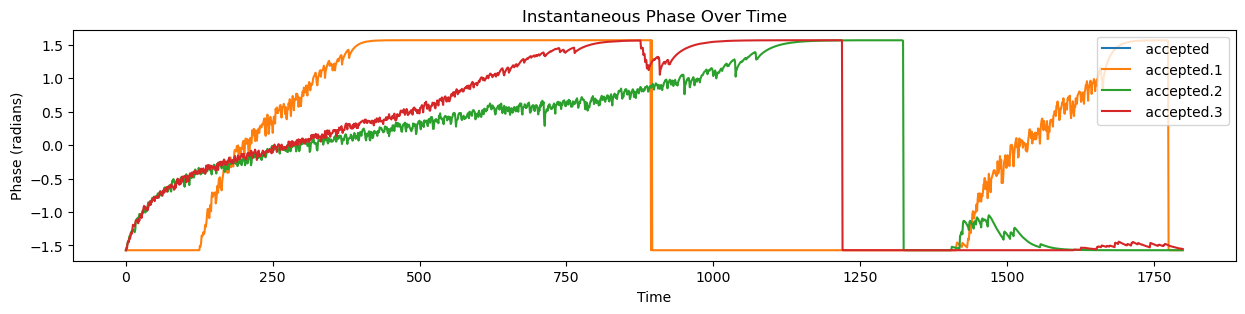

In [172]:
# 選擇繪製圖表的訊號
signal_names = list(phases.keys())[:]  # 選取訊號進行繪製

plt.figure(figsize=(15, 3))
for name in signal_names:
    plt.plot(phases[name], label=f'{name}')

plt.title('Instantaneous Phase Over Time')
plt.xlabel('Time')
plt.ylabel('Phase (radians)')
plt.legend(loc=1)
plt.show()

### 5.1 不考慮細胞間的distance

In [173]:
# 初始化一個同步化矩陣
synchronization_matrix = np.full((len(data.columns), len(data.columns)), np.nan)  # 使用np.nan初始化

# 計算每對訊號之間的synchronization index，並填入矩陣中
for i, neuron_i in enumerate(data.columns):
    for j, neuron_j in enumerate(data.columns):
        if i == j:
            continue  # 跳过与自身的比较
        cv = calculate_circular_variance(phases[neuron_i], phases[neuron_j])
        synchronization_matrix[i, j] = cv if cv is not None else 0

# 計算每個訊號的平均synchronization index
synchronization_indices = np.nanmean(synchronization_matrix, axis=1)

# Calculate the mean of synchronization_indices
mean_synchronization_index = np.mean(synchronization_indices)
mean_synchronization_index = round(mean_synchronization_index,8)

# Print the mean
print("Mean Synchronization Index:", mean_synchronization_index)

Mean Synchronization Index: 0.25052396


### 5.2 考慮細胞間的distance，再去計算synchronization index

In [174]:
# 載入和處理數據
data_props = pd.read_csv('N_O1_3_trace-props.csv')
data_props = data_props.drop(columns=['Status', 'ColorR', 'ColorG', 'ColorB', 'NumComponents', 'ActiveSegment0'])

# Prepare the data for plotting
x = data_props['CentroidX'].tolist()
y = data_props['CentroidY'].tolist()
sizes = [size * 1 for size in data_props['Size'].tolist()]  # Scale up sizes for better visibility

# 考慮顯示器的實際物理尺寸：X*Y=700*700 (micrometer)
image_width_in_micrometers = 700  # 影像的寬度，單位是微米
image_height_in_micrometers = 700  # 影像的高度

# 考虑图像的分辨率：X*Y pixels = 495*512，在水平方向和垂直方向上各有多少像素點。
image_width_in_pixels = 495  # 影像的寬度，單位是像素
image_height_in_pixels = 512  # 影像的高度

# 計算轉換比率
micrometers_per_pixel_x = image_width_in_micrometers / image_width_in_pixels
micrometers_per_pixel_y = image_height_in_micrometers / image_height_in_pixels

# 使用轉換比率將像素座標轉換為微米座標
x_micrometers = [x_pos * micrometers_per_pixel_x for x_pos in x]
y_micrometers = [y_pos * micrometers_per_pixel_y for y_pos in y]

# 用轉換後的座標重新繪製散點圖
plt.figure(figsize=(5, 5))
plt.scatter(x_micrometers, y_micrometers, c='red', s=sizes, alpha=0.5, marker='o')
plt.title('Cell Positions and Sizes in Micrometers')
plt.xlabel('Centroid X (μm)')
plt.ylabel('Centroid Y (μm)')
plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'N_O1_3_trace-props.csv'

### (無循環)直接設定distance_threshold

In [ ]:
# 初始化一個同步化矩陣，這次我們會在計算synchronization index前檢查細胞間的距離
synchronization_matrix = np.full((len(data.columns), len(data.columns)), np.nan)  # 使用np.nan初始化

# 計算每對細胞之間的距離
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

distance_threshold = 100

# 計算每對細胞之間的synchronization index，只考慮距離在設定閾值以內的細胞對
for i, neuron_i in enumerate(data.columns):
    x_i, y_i = x_micrometers[i], y_micrometers[i]  # 取得細胞i的座標
    for j, neuron_j in enumerate(data.columns):
        if i == j:
            continue  # 跳過與自身的比較
        x_j, y_j = x_micrometers[j], y_micrometers[j]  # 取得細胞j的座標
        dist = calculate_distance(x_i, y_i, x_j, y_j)  # 計算距離
        if dist <= distance_threshold:  # 只有當細胞間的距離小於等於閾值時，才計算synchronization index
            cv = calculate_circular_variance(phases[neuron_i], phases[neuron_j])
            synchronization_matrix[i, j] = cv if cv is not None else 0

# 計算每個細胞的平均synchronization index，排除NaN值
synchronization_indices = np.nanmean(synchronization_matrix, axis=1)

# 計算平均synchronization index
mean_synchronization_index = np.nanmean(synchronization_indices)  # 使用np.nanmean確保NaN值被忽略
mean_synchronization_index = round(mean_synchronization_index, 8)

print("Mean Synchronization Index considering distance:", mean_synchronization_index)

### (循環)考慮所有可能的threshold

In [ ]:
# 計算每對細胞之間的距離
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# 所有細胞對之間可能的最大距離
distance_threshold_max = np.sqrt(max(x_micrometers)**2 + max(y_micrometers)**2)

distance_threshold = 1
mean_synchronization_index_ls = []
distance_threshold_ls = []


while distance_threshold <= distance_threshold_max:
    # 初始化一個同步化矩陣，這次我們會在計算synchronization index前檢查細胞間的距離
    synchronization_matrix = np.full((len(data.columns), len(data.columns)), np.nan)  # 使用np.nan初始化
    
    # 計算每對細胞之間的synchronization index，只考慮距離在設定閾值以內的細胞對
    for i, neuron_i in enumerate(data.columns):
        x_i, y_i = x_micrometers[i], y_micrometers[i]  # 取得細胞i的座標
        for j, neuron_j in enumerate(data.columns):
            if i == j:
                continue  # 跳過與自身的比較
            x_j, y_j = x_micrometers[j], y_micrometers[j]  # 取得細胞j的座標
            dist = calculate_distance(x_i, y_i, x_j, y_j)  # 計算距離
            if dist <= distance_threshold:  # 只有當細胞間的距離小於等於閾值時，才計算synchronization index
                cv = calculate_circular_variance(phases[neuron_i], phases[neuron_j])
                synchronization_matrix[i, j] = cv if cv is not None else 0
    
    # 計算每個細胞的平均synchronization index，排除NaN值
    synchronization_indices = np.nanmean(synchronization_matrix, axis=1)
    
    # 計算平均synchronization index
    mean_synchronization_index = np.nanmean(synchronization_indices)  # 使用np.nanmean确保NaN值被忽略
    mean_synchronization_index = round(mean_synchronization_index, 8)

    # 為 mean_synchronization_index_ls 添加 element
    mean_synchronization_index_ls.append(mean_synchronization_index)
    distance_threshold_ls.append(distance_threshold)
    distance_threshold += 1

mean_synchronization_index_ls = [0 if np.isnan(x) else x for x in mean_synchronization_index_ls]

In [ ]:
plt.plot(distance_threshold_ls, mean_synchronization_index_ls)

In [ ]:
# To export individual value in mean_synchronization_index_ls
distance_threshold_index = 100  # change value here
mean_synchronization_index_ls[distance_threshold_index-1]

In [33]:
%%capture
mean_synchronization_index_ls

NameError: name 'mean_synchronization_index_ls' is not defined

### Plotting (under revision) 
1. Frequency
2. Amplitude
3. Synchronization index for each fov (field of view)

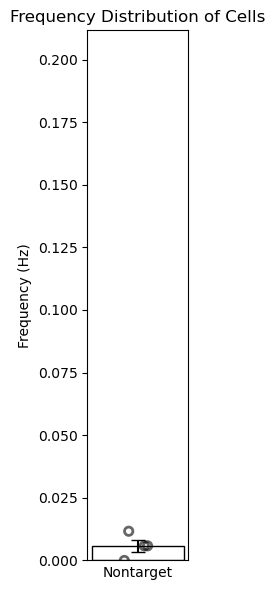

In [ ]:
'''plotting of frequency'''
# 繪製散佈圖和平均頻率的長條圖
plt.figure(figsize=(2, 6))

# 為散佈圖的橫座標添加隨機偏移量以避免重疊
x_random_offsets = np.random.rand(len(cell_frequencies_Hz)) * 0.8 - 0.4
x_values = np.ones(len(cell_frequencies_Hz)) + x_random_offsets
plt.scatter(x_values, cell_frequencies_Hz, alpha=0.6, facecolors='none', edgecolor='black', linewidth=2)

# 長條圖顯示平均頻率
plt.bar(1, average_frequency_Hz, width=1.8, edgecolor='black', facecolor='none', linewidth=1)

# 計算SEM
std_dev_frequencies_Hz = np.std(cell_frequencies_Hz, ddof=1)
n_frequencies_Hz = len(cell_frequencies_Hz)
sem_frequencies_Hz = std_dev_frequencies_Hz / np.sqrt(n_frequencies_Hz)

# 在長條圖上添加SEM作为误差线
plt.errorbar(1, average_frequency_Hz, yerr=sem_frequencies_Hz, fmt='none', color='black', capsize=5)


# 設定圖表的標題和軸標籤
plt.title('Frequency Distribution of Cells')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Nontarget')
plt.xticks([])  # Hides x ticks
plt.ylim(0, np.max(cell_frequencies_Hz) + 0.2)  # 確保y軸上限留有足夠空間


plt.tight_layout()
plt.show()

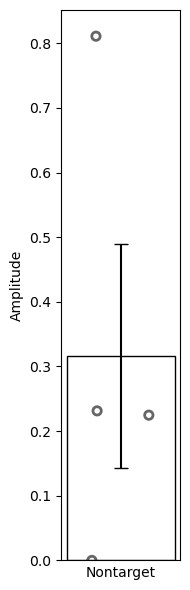

In [ ]:
'''plotting amplitude'''
# 計算平均振幅和標準差
average_amplitude = np.nanmean(amplitudes)  # 平均振幅
std_amplitude = np.nanstd(amplitudes)   # 振幅的標準差

# 數據視覺化
plt.figure(figsize=(2, 6))

# 散布圖顯示個別振幅
offsets = np.random.rand(len(amplitudes)) * 0.8 - 0.4
x_values = np.ones(len(amplitudes)) + offsets
plt.scatter(x_values, amplitudes, alpha=0.6, facecolors='none', edgecolor='black', linewidth=2, label='Individual Amplitudes')

# 長條圖顯示整體平均振幅
plt.bar(1, average_amplitude, width=1.0, edgecolor='black', facecolor='none', linewidth=1)

# 計算SEM
std_dev_amplitude = np.std(amplitudes, ddof=1)
n_amplitude = len(amplitudes)
sem_amplitude = std_dev_amplitude / np.sqrt(n_amplitude)

# 在長條圖上添加SEM作为误差线
plt.errorbar(1, average_amplitude, yerr=sem_amplitude, fmt='none', color='black', capsize=5)


plt.ylabel('Amplitude')
plt.xlabel('Nontarget')
plt.xticks([])   # Hides x ticks

plt.tight_layout()
plt.show()

In [37]:
# 複製每一個csv檔的 Mean Synchronization Index，並加入 fov_synchronization_indices array
fov_synchronization_indices_NTKORe = np.array([[0.27398593], [0.11903799], [0.10445933]])
fov_average_sync_index = [0,0,0]
sem = [0,0,0]
group = ['NonTarget', 'KnockOut', 'Rescue']

# 使用matplotlib繪製synchronization index的圖形
plt.figure(figsize=(6, 6))

for i in range(np.shape(fov_synchronization_indices_NTKORe)[0]):
    # 散佈圖顯示每個訊號的synchronization index
    offsets[i] = np.random.rand(len(fov_synchronization_indices_NTKORe[i])) * 0.8 - 0.4
    x_values = np.ones(np.shape(fov_synchronization_indices_NTKORe[i])) + offsets[i]
    plt.scatter(x_values+1, fov_synchronization_indices_NTKORe[i], alpha=0.6, facecolors='none', edgecolors='black', linewidth=2)

    # 長條圖顯示所有訊號的平均synchronization index
    fov_average_sync_index[i] = np.nanmean(fov_synchronization_indices_NTKORe[i])

    # 計算SEM
    std_dev = np.std(fov_synchronization_indices_NTKORe[i], ddof=1)  # 使用所有觀測值的標準差
    n = len(fov_synchronization_indices_NTKORe[i])  # 觀測值數量
    sem[i] = std_dev / np.sqrt(n)  # 標準誤差的平均值

    # 在長條圖上加入SEM作為誤差線
    plt.errorbar(i, fov_average_sync_index[i], yerr=sem[i], fmt='none', color='black', capsize=5)

plt.bar(group, fov_average_sync_index, width=1.0, label=group, edgecolor='black', facecolor='none', linewidth=1)

plt.ylabel('fov_Synchronization Index')
# plt.xlabel(group[i])
plt.xticks([]) # Hides x ticks

plt.tight_layout()
plt.show()

NameError: name 'offsets' is not defined

<Figure size 600x600 with 0 Axes>